In [11]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Effects of imbalanced class
---

In [12]:
# Adjust weights to make the dataset imbalanced
random_state = 42 # choose between 42 or 69
X, y = make_classification(n_samples=1000, n_features=2,
                    n_informative=2, n_redundant=0, n_repeated=0, n_classes=2,
                    n_clusters_per_class=2, weights=[0.9, 0.1], # 90% of class 0, 10% of class 1
                    flip_y=0.01, class_sep=1.5, hypercube=True,
                    shift=0.0, scale=1.0, shuffle=True, random_state=random_state)

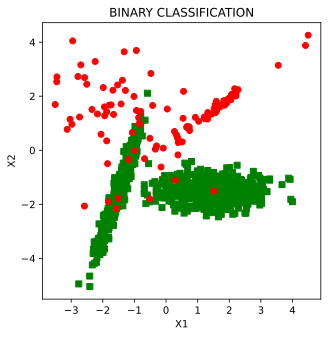

In [13]:
# convert to a pytorch tensor
data = torch.tensor(X).float()
labels = torch.tensor(y).float()
labels = labels.view(-1, 1)

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'gs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ro')
plt.title('BINARY CLASSIFICATION')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [14]:
# a function that creates the ANN model

def model():
    # model architecture
    ann = nn.Sequential(
      nn.Linear(2,1),   # input layer
      nn.ReLU(),        # activation unit
      nn.Linear(1,1),   # output unit
        )

    # loss function
    lossfunc = nn.BCEWithLogitsLoss()

    # optimizer
    optim = torch.optim.SGD(ann.parameters(),lr=.01)

    # model output
    return ann,lossfunc,optim

In [15]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# global parameter
epochs = 200

def train(trainProp):

    # initialize losses
    losses = torch.zeros(epochs)
    train_auc = []
    test_auc  = []

    # loop over epochs
    for i in range(epochs):

        # separate train from test data
        X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=trainProp, random_state=None, shuffle=True, stratify=None)

        # forward pass and loss
        pred_train = ann(X_train)
        loss = lossfunc(pred_train, y_train)

        # backprop
        optim.zero_grad()
        loss.backward()
        optim.step()

        # get predicted probabilities using sigmoid for binary classification
        pred_train_proba = torch.sigmoid(pred_train).detach().numpy()
        pred_test_proba = torch.sigmoid(ann(X_test)).detach().numpy()

        # compute ROC-AUC score for train set
        train_auc.append(roc_auc_score(y_train.detach().numpy(), pred_train_proba))

        # compute ROC-AUC score for test set
        test_auc.append(roc_auc_score(y_test.detach().numpy(), pred_test_proba))

    # function output
    return train_auc, test_auc


# Test the model by running it once

In [16]:
# create a model
ann,lossfunc,optim = model()

# train the model
# NOTE: the input is the training proportion, not the test proportion!
train_auc,test_auc = train(.8)


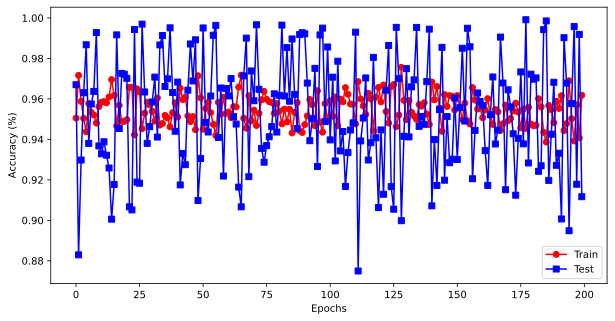

In [17]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(train_auc,'ro-')
plt.plot(test_auc,'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.show()

# What happened here?
---
Look at the graph of the data.


Important: Test accuracy should not exceed training accuracy, as the model is specifically optimized for the training data. Possible reasons for this behavior include:

1. The test dataset may differ from the training dataset. It’s crucial to perform a proper train/test split, ensuring both sets come from the same underlying distribution. It’s likely that the test data used was from a completely different, potentially easier, dataset.

2. Excessive regularization was applied. However, even with high regularization, the test and training data distributions would need to differ for this result to occur.

# Now for the experiment

In [18]:
trainSetSizes = np.linspace(.2,.95,10)

alltrain_auc = np.zeros((len(trainSetSizes),epochs))
alltest_auc = np.zeros((len(trainSetSizes),epochs))

for i in range(len(trainSetSizes)):

    # create a model
    ann,lossfunc,optim = model()

    # train the model
    train_auc,test_auc = train(trainSetSizes[i])

    # store the results
    alltrain_auc[i,:] = train_auc
    alltest_auc[i,:] = test_auc

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


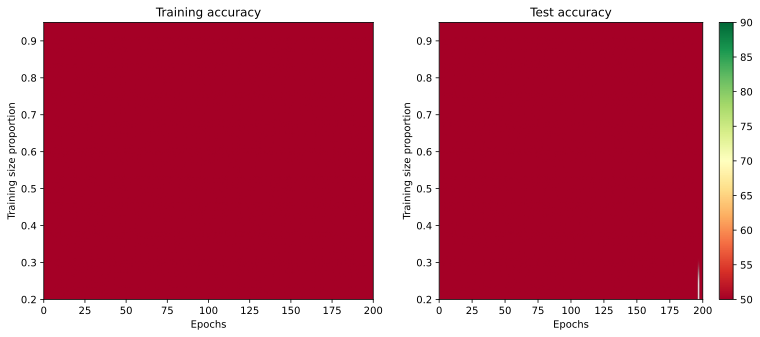

In [19]:
fig,ax = plt.subplots(1,2,figsize=(13,5))

# First plot with red-to-green spectrum
ax[0].imshow(alltrain_auc, aspect='auto', vmin=50, vmax=90,
             extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training size proportion')
ax[0].set_title('Training accuracy')

# Second plot with red-to-green spectrum
p = ax[1].imshow(alltest_auc, aspect='auto', vmin=50, vmax=90,
                 extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training size proportion')
ax[1].set_title('Test accuracy')

# Adding a colorbar
fig.colorbar(p, ax=ax[1])

plt.show()

# Experiments

1. Redo the experiment but this time stratify the train-test split in terms of the y values. Compare the result to the original, provide an explaination.

2. Redo the experiment but this time try to set seed (any number) the experiment without stratification. Compare the result to the original, provide an explaination.

3. Redo the experiment but this time try to set seed (any number) the experiment with stratification. Compare the result to the original, provide an explaination.

4. Try to improve the model by adding more layers, and changing the value of the learning rate. Creat a bubblechart with the x-axis as the epochs, y-axis as the learning rate, the size of the bubble as the layers, and the color as the accuracy.

5. Try changing the random state of the make_classifier function to generate a slightly different dataset, run the original code, then perform the experiments.

6. Think of different ways to address the class imbalance.

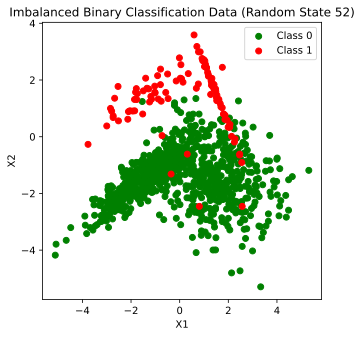

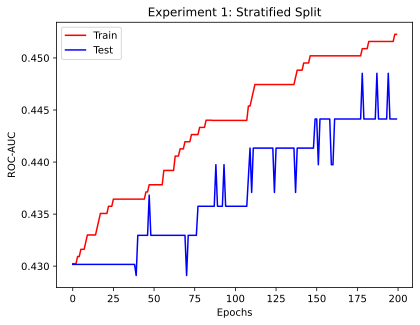

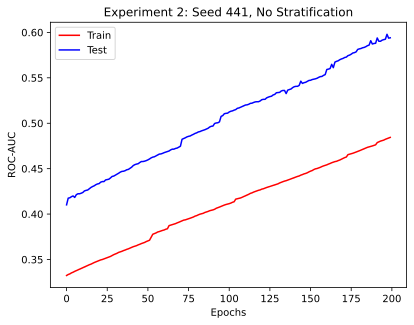

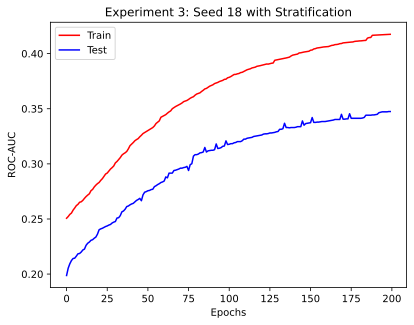

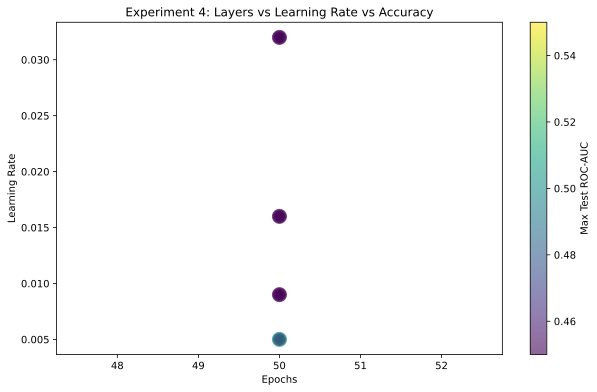

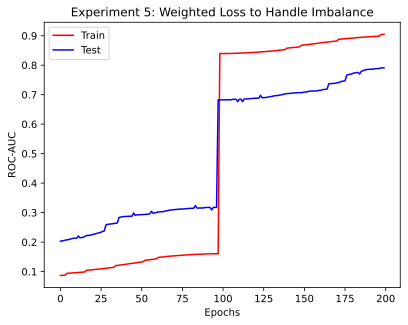

In [20]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


def create_model(layers=1, lr=0.01):
    """Create a simple ANN model.
    Args:
        layers: number of hidden layers (each with 1 neuron)
        lr: learning rate for SGD
    """
    modules = [nn.Linear(2, 1), nn.ReLU()]
    for _ in range(layers-1):
        modules.append(nn.Linear(1, 1))
        modules.append(nn.ReLU())
    modules.append(nn.Linear(1, 1))

    ann = nn.Sequential(*modules)
    lossfunc = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(ann.parameters(), lr=lr)

    return ann, lossfunc, optim


def train_model(ann, lossfunc, optim, train_prop=0.8, stratify=False, seed=None, epochs=200):
    """Train ANN on imbalanced dataset"""

    # Dataset split
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, train_size=train_prop, random_state=seed, stratify=labels if stratify else None
    )

    train_auc = []
    test_auc = []

    for epoch in range(epochs):
        # Forward pass
        pred_train = ann(X_train)
        loss = lossfunc(pred_train, y_train)

        # Backprop
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Probabilities
        pred_train_proba = torch.sigmoid(pred_train).detach().numpy()
        pred_test_proba = torch.sigmoid(ann(X_test)).detach().numpy()

        # ROC-AUC
        train_auc.append(roc_auc_score(y_train.detach().numpy(), pred_train_proba))
        test_auc.append(roc_auc_score(y_test.detach().numpy(), pred_test_proba))

    return train_auc, test_auc


random_state = 52  # updated random state
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
    n_classes=2, n_clusters_per_class=2, weights=[0.9, 0.1],
    flip_y=0.01, class_sep=1.5, random_state=random_state
)
data = torch.tensor(X).float()
labels = torch.tensor(y).float().view(-1, 1)

# Visualize dataset
plt.figure(figsize=(5,5))
plt.scatter(data[labels[:,0]==0,0], data[labels[:,0]==0,1], color='green', label='Class 0')
plt.scatter(data[labels[:,0]==1,0], data[labels[:,0]==1,1], color='red', label='Class 1')
plt.title("Imbalanced Binary Classification Data (Random State 52)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()


# Experiment 1:
ann, lossfunc, optim = create_model()
train_auc_strat, test_auc_strat = train_model(ann, lossfunc, optim, train_prop=0.8, stratify=True) # stratified yah

plt.plot(train_auc_strat, 'r-', label='Train')
plt.plot(test_auc_strat, 'b-', label='Test')
plt.title("Experiment 1: Stratified Split")
plt.xlabel("Epochs")
plt.ylabel("ROC-AUC")
plt.legend()
plt.show()


# Experiment 2:
ann, lossfunc, optim = create_model()
train_auc_seed441, test_auc_seed441 = train_model(
    ann, lossfunc, optim, train_prop=0.8, stratify=False, seed=441 #Seed 441, naur stratification
)

plt.plot(train_auc_seed441, 'r-', label='Train')
plt.plot(test_auc_seed441, 'b-', label='Test')
plt.title("Experiment 2: Seed 441, No Stratification")
plt.xlabel("Epochs")
plt.ylabel("ROC-AUC")
plt.legend()
plt.show()


# Experiment 3:
ann, lossfunc, optim = create_model()
train_auc_seed18_strat, test_auc_seed18_strat = train_model(
    ann, lossfunc, optim, train_prop=0.8, stratify=True, seed=18 #Seed 18, with stratification
)

plt.plot(train_auc_seed18_strat, 'r-', label='Train')
plt.plot(test_auc_seed18_strat, 'b-', label='Test')
plt.title("Experiment 3: Seed 18 with Stratification")
plt.xlabel("Epochs")
plt.ylabel("ROC-AUC")
plt.legend()
plt.show()


# Experiment 4: Improved model with layers & learning rates (bubble chart)
layers_options = [1,2,3,4]
learning_rates = [0.009, 0.016, 0.032, 0.005]
epochs = 50

results = []

for layers in layers_options:
    for lr in learning_rates:
        ann, lossfunc, optim = create_model(layers=layers, lr=lr)
        train_auc, test_auc = train_model(ann, lossfunc, optim, train_prop=0.8, stratify=True, epochs=epochs)
        results.append((layers, lr, max(test_auc)))

# Bubble chart
plt.figure(figsize=(10,6))
for layers, lr, auc in results:
    plt.scatter(x=epochs, y=lr, s=layers*50, c=auc, cmap='viridis', alpha=0.6)
plt.colorbar(label='Max Test ROC-AUC')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Experiment 4: Layers vs Learning Rate vs Accuracy')
plt.show()


# Experiment 5: Weighted loss to handle imbalance
pos_weight = torch.tensor([9.0])  # weight for minority class
lossfunc_weighted = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
ann, _, optim = create_model()
train_auc_w, test_auc_w = train_model(ann, lossfunc_weighted, optim, train_prop=0.8, stratify=True)

plt.plot(train_auc_w, 'r-', label='Train')
plt.plot(test_auc_w, 'b-', label='Test')
plt.title("Experiment 5: Weighted Loss to Handle Imbalance")
plt.xlabel("Epochs")
plt.ylabel("ROC-AUC")
plt.legend()
plt.show()
